# Reconhecimento de atividade humana usando conjunto de dados de smartphones

## Random Forest com classificação e clustering - Preditor de atividade humana

A Contoso Behavior Systems está desenvolvendo uma ferramenta de IA que tentará reconhecer a atividade humana (1-Walking, 2-Walking upstairs, 3-Walking downstairs, 4-Sentado, 5-Standing ou 6-Laying) usando os sensores do smartphone. O que significa que, usando os métodos a seguir, o smartphone pode detectar o que estamos fazendo no momento.

O banco de dados do Human Activity Recognition foi construído a partir de gravações de 30 participantes do estudo realizando atividades de vida diária (AVD) enquanto carregavam um smartphone montado na cintura com sensores inerciais embutidos. O objetivo é classificar as atividades em uma das seis atividades realizadas.

### Descrição do experimento

Os experimentos foram realizados com um grupo de 30 voluntários em uma faixa etária de 19 a 48 anos. Cada pessoa realizou seis atividades (1-Walking, 2-Walking upstairs, 3-Walking downstairs, 4-Sentado, 5-Standing ou 6-Laying) usando um smartphone (Samsung Galaxy S II) na cintura. Usando seu acelerômetro e giroscópio embutidos, capturamos a aceleração linear 3-axial e a velocidade angular 3-axial a uma taxa constante de 50Hz. Os experimentos foram gravados em vídeo para rotular os dados manualmente. O conjunto de dados obtido foi particionado aleatoriamente em dois conjuntos, onde 70% dos voluntários foram selecionados para gerar os dados de treinamento e 30% os dados de teste.

Os sinais do sensor (acelerômetro e giroscópio) foram pré-processados ​​pela aplicação de filtros de ruído e então amostrados em janelas deslizantes de largura fixa de 2,56 seg e sobreposição de 50% (128 leituras/janela). O sinal de aceleração do sensor, que possui componentes gravitacionais e de movimento corporal, foi separado por meio de um filtro passa-baixo Butterworth em gravidade e aceleração do corpo. A força gravitacional é considerada como tendo apenas componentes de baixa frequência, portanto, um filtro com frequência de corte de 0,3 Hz foi usado. De cada janela, um vetor de features foi obtido pelo cálculo de variáveis no domínio do tempo e da frequência.

### Informações de atributo

* Para cada registro no conjunto de dados, o seguinte é fornecido:
* Aceleração triaxial do acelerômetro (aceleração total) e a aceleração corporal estimada.
* Velocidade angular triaxial do giroscópio.
* Um vetor de 561 features com variáveis ​​de domínio de tempo e frequência.
* Seu rótulo de atividade.
* Um identificador do sujeito que realizou o experimento.

### Planejamento

Quando temos um problema que sabemos resolver, podemos criar uma lista de etapas para nos guiar pelo experimento.

1. Importe as bibliotecas Python necessárias
2. Carregue e analise os dados
3. Encontre correlações entre as features
4. Divida os dados em dados de treinamento e teste (dados de validação)
5. Preveja a atividade usando Regressão Logística

### 1. Importe as bibliotecas Python necessárias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as error_metric
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import VarianceThreshold

### 2. Carregue e analise os dados

In [3]:
#train = pd.read_csv("https://github.com/microsoft/Reactors/raw/main/workshop-resources/data-science-and-machine-learning/Data_Science_2/human-behavior-project/Data/train.csv")
train = pd.read_csv("Data/train.csv")

#test = pd.read_csv("https://github.com/microsoft/Reactors/raw/main/workshop-resources/data-science-and-machine-learning/Data_Science_2/human-behavior-project/Data/test.csv")
test = pd.read_csv("Data/test.csv")


In [4]:
print("--------- Training Data ---------")
print(train.head())
print("--------- Test Data ---------")
print(test.head())

--------- Training Data ---------
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  t

#### Verifique se há valores nulos nos dados

In [4]:
print("Training Data:",train.isnull().values.any())
print("Testing Data:",test.isnull().values.any())

Training Data: False
Testing Data: False


Sem valores nulos, vamos prosseguir

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


#### Removendo dados que não usaremos, neste caso não nos importamos com quem foi o "sujeito"
Olhando os valores principais, podemos notar que a coluna subject não será útil aqui, então vamos retirá-la de ambos os conjuntos de dados. Como há muitas colunas nos dados, você pode não tê-la notado, mas é apenas um número que foi usado arbitrariamente para identificar os indivíduos.

### Eliminando dados

Lembre-se de que podemos usar o método built-in .drop para remover colunas do conjunto de dados. Podemos usar a ajuda interativa para ter certeza de que sabemos quais são todos os parâmetros - para acessar a ajuda, digite train.drop? o ponto de interrogação permite ao interpretador saber que queremos ajuda.

No método [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html), o parâmetro 'axis' significa que estamos descartando uma coluna e o parâmetro 'inplace' significa exatamente isso: faça a operação no local e retorne None.

In [5]:
# We can do these both at once:

train.drop('subject', axis =1, inplace=True)
test.drop('subject', axis =1, inplace=True)

In [6]:
# Verify that the column was dropped
print("--------- Training Data ---------")
print(train.head())
print("--------- Test Data ---------")
print(test.head())

--------- Training Data ---------
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  t

In [10]:
# Let's creat a list of all the column labels.
rem_cols2 = test.columns.tolist()
rem_cols2

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X',
 'tBodyAcc-max()-Y',
 'tBodyAcc-max()-Z',
 'tBodyAcc-min()-X',
 'tBodyAcc-min()-Y',
 'tBodyAcc-min()-Z',
 'tBodyAcc-sma()',
 'tBodyAcc-energy()-X',
 'tBodyAcc-energy()-Y',
 'tBodyAcc-energy()-Z',
 'tBodyAcc-iqr()-X',
 'tBodyAcc-iqr()-Y',
 'tBodyAcc-iqr()-Z',
 'tBodyAcc-entropy()-X',
 'tBodyAcc-entropy()-Y',
 'tBodyAcc-entropy()-Z',
 'tBodyAcc-arCoeff()-X,1',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,1',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,1',
 'tBodyAcc-arCoeff()-Z,2',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tGravityAcc-mean()-X',
 'tGravityA

In [8]:
# We should also verify the different datatypes in our data, in this case we can see we have 
# 561 float type data dimensions and 1 object dimension.
print('----------TRAIN------------')
print(train.dtypes.value_counts())
print('----------TEST------------')
print(test.dtypes.value_counts())

----------TRAIN------------
float64    561
object       1
dtype: int64
----------TEST------------
float64    561
object       1
dtype: int64


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 31.5+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 12.6+ MB


### Checkpoint

Devemos reescalar os dados? A reescalação de um conjunto de dados geralmente produz um conjunto de dados melhor e previsões mais precisas. Primeiro, verificamos o intervalo (o mínimo e o máximo) para cada um dos conjuntos de dados. Vamos tentar usar o método .describe() e vamos excluir a coluna de atividade que é a última coluna.

### Reescalando dados

Quando 'reescalamos' os dados, adicionamos ou subtraímos uma constante e multiplicamos ou dividimos por constante para os valores originais. Um bom exemplo disso é quando convertemos ou transformamos os dados de temperatura de Celsius para Fahrenheit.

### Padronização e normalização de nossos dados

Quando padronizamos e normalizamos dados, essencialmente estamos tentando criar dados que sejam facilmente comparáveis ​​- como transformar uma comparação "maçãs com laranjas" em uma comparação "maçãs com maçãs". Padronizar as features em torno da média 0 com um desvio padrão de 1 é importante quando comparamos medidas que têm unidades diferentes. Variáveis ​​que são medidas em escalas diferentes não contribuem igualmente para a análise e podem acabar criando um viés.

Da mesma forma, o objetivo da normalização é alterar os valores das colunas numéricas no conjunto de dados para uma escala comum, sem distorcer as diferenças nos intervalos de valores. Para aprendizado de máquina, nem todo conjunto de dados requer normalização. É necessário apenas quando as features têm intervalos diferentes.

### Quando devemos normalizar ou padronizar?

**Normalização** é uma boa técnica para usar quando você não sabe a distribuição de seus dados ou quando sabe que a distribuição não é Gaussiana (uma curva em sino). A normalização é útil quando seus dados têm escalas variáveis ​​e o algoritmo que você está usando não faz suposições sobre a distribuição de seus dados, como vizinhos k-mais próximos e redes neurais artificiais.

**Padronização** assume que seus dados têm uma distribuição gaussiana. Isso não precisa ser estritamente verdadeiro, mas a técnica é mais eficaz se a distribuição de seus atributos for gaussiana. A padronização é útil quando seus dados têm escalas variáveis ​​e o algoritmo que você está usando faz suposições sobre seus dados terem uma distribuição Gaussiana, como regressão linear, regressão logística e análise de discriminante linear.

In [14]:
print('----------TRAIN------------')
print(train.describe())

----------TRAIN------------
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        7352.000000        7352.000000        7352.000000   
mean            0.274488          -0.017695          -0.109141   
std             0.070261           0.040811           0.056635   
min            -1.000000          -1.000000          -1.000000   
25%             0.262975          -0.024863          -0.120993   
50%             0.277193          -0.017219          -0.108676   
75%             0.288461          -0.010783          -0.097794   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       7352.000000       7352.000000       7352.000000       7352.000000   
mean          -0.605438         -0.510938         -0.604754         -0.630512   
std            0.448734          0.502645          0.418687          0.424073   
min           -1.000000         -0.999873         -1.

In [15]:
print('----------TEST------------')
print(test.describe())

----------TEST------------
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        2947.000000        2947.000000        2947.000000   
mean            0.273996          -0.017863          -0.108386   
std             0.060570           0.025745           0.042747   
min            -0.592004          -0.362884          -0.576184   
25%             0.262075          -0.024961          -0.121162   
50%             0.277113          -0.016967          -0.108458   
75%             0.288097          -0.010143          -0.097123   
max             0.671887           0.246106           0.494114   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       2947.000000       2947.000000       2947.000000       2947.000000   
mean          -0.613635         -0.508330         -0.633797         -0.641278   
std            0.412597          0.494269          0.362699          0.385199   
min           -0.999606         -1.000000         -0.9

### Escalando
 
Agora que entendemos por que escalamos os dados, devemos fazer isso aqui?

Aqui não é necessário. Vemos que o min = -1 e o max = +1, portanto, não há necessidade de dimensionar esses dados. Não parece haver dados estranhos ou remotos. Em outras palavras, todos os dados estão dentro de uma faixa que faz sentido. Vamos continuar.

In [16]:
# Notice how we can use .tail() to also examine the datatypes of the last 

train.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

Eles têm os mesmos tipos de dados. Ou seja, a maioria das features é float e uma é do tipo objeto. Vamos ver o que está na feature 'Activity', do tipo objeto, e separá-la do resto.

In [17]:
object_feature = train.dtypes == np.object
object_feature = train.columns[object_feature]
object_feature

Index(['Activity'], dtype='object')

Como podemos ver, o único tipo de dados de objeto no conjunto de dados de treinamento e teste é o recurso Activity. Vamos dar uma olhada nisso ...

In [18]:
train.Activity.value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

Precisamos codificar a coluna Activity porque sklearn não aceitará dados categóricos como nossos rótulos de coluna. Usaremos [LabelEncoder] (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) para codificar a coluna 'Activity'.

#### LabelEndcoder em sklearn
A função LabelEncoder pode fazer algumas coisas por nós. Ele pode normalizar nomes de coluna de rótulo ou também pode converter rótulos categóricos em valores numéricos, semelhante ao processo de ["one-hot-encoding" no Azure ML Studio] (https://docs.microsoft.com/en-us/azure/machine-learning/ studio-module-reference/convert-to-indicator-values), que essencialmente nos permite criar um sistema binário para converter dados categóricos em números.

Vamos fazer isso aqui com o LabelEncoder:

In [11]:
le = LabelEncoder()
for x in [train, test]:
    x['Activity'] = le.fit_transform(x.Activity)

In [12]:
train.Activity.sample(5)

7281    3
5401    3
3477    1
5475    2
6977    2
Name: Activity, dtype: int64

In [21]:
test.Activity.sample(5)

1334    4
2392    2
663     1
1200    5
2887    3
Name: Activity, dtype: int64

### 3 Encontrando a correlação / relações entre as features

Correlação refere-se à relação mútua e associação entre quantidades e é geralmente usada para expressar uma quantidade em termos de sua relação com outras quantidades. A correlação pode ser positiva (as variáveis ​​mudam na mesma direção), negativa (as variáveis ​​mudam na direção oposta ou neutra (sem correlação).

As variáveis ​​em um conjunto de dados podem estar relacionadas de várias maneiras e por vários motivos:

- Elas podem depender de valores de outras variáveis
- Elas podem estar associadas entre si
- Ambas podem depender de uma terceira variável.

Para este projeto, usaremos o método pandas .corr() para calcular a correlação entre as colunas do dataframe.

In [13]:
# Exclude the Activity column
feature_cols = train.columns[: -1] 

# Calculate the correlation values
correlated_values = train[feature_cols].corr()

# Stack the data and convert to a dataframe
correlated_values = (correlated_values.stack().to_frame().reset_index()
                    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0:'Correlations'}))
correlated_values.head()

,Feature_1,Feature_2,Correlations
0,tBodyAcc-mean()-X,tBodyAcc-mean()-X,1.000000
1,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,0.148061
2,tBodyAcc-mean()-X,tBodyAcc-mean()-Z,-0.256952
3,tBodyAcc-mean()-X,tBodyAcc-std()-X,0.000619
4,tBodyAcc-mean()-X,tBodyAcc-std()-Y,-0.021903


In [14]:
# Create an abs_correlation column
correlated_values['abs_correlation'] = correlated_values.Correlations.abs()
correlated_values.head()


,Feature_1,Feature_2,Correlations,abs_correlation
0,tBodyAcc-mean()-X,tBodyAcc-mean()-X,1.000000,1.000000
1,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,0.148061,0.148061
2,tBodyAcc-mean()-X,tBodyAcc-mean()-Z,-0.256952,0.256952
3,tBodyAcc-mean()-X,tBodyAcc-std()-X,0.000619,0.000619
4,tBodyAcc-mean()-X,tBodyAcc-std()-Y,-0.021903,0.021903


In [24]:
# Picking most correlated features
train_fields = correlated_values.sort_values('Correlations', ascending = False).query('abs_correlation>0.8')
train_fields.sample(5)

,Feature_1,Feature_2,Correlations,abs_correlation
112888,tBodyAccMag-std(),tBodyGyro-mad()-Y,0.845918,0.845918
12057,tBodyAcc-iqr()-Z,fBodyAcc-max()-Z,0.954655,0.954655
78079,tBodyGyro-iqr()-X,tBodyAccJerk-iqr()-Y,0.885586,0.885586
250649,fBodyGyro-entropy()-Y,fBodyGyro-iqr()-Y,0.843869,0.843869
152797,fBodyAcc-mad()-Y,tBodyAccMag-sma(),0.966421,0.966421


### 4 Dividindo os dados em DataFrames de treinamento e validação

Se treinarmos um modelo e testá-lo com os mesmos dados, veremos algo muito interessante - provavelmente nada além de pontuações perfeitas e não conseguirá prever nada de útil em novos dados.

Quando essa situação surge, ocorre o chamado de overfitting, que é algo que discutiremos mais em nossos workshops de aprendizado de máquina. Para isso, é prática comum, ao realizar um experimento de aprendizado de máquina (supervisionado), manter parte dos dados disponíveis como um conjunto de teste x_test, y_test. Também realizaremos uma etapa de validação cruzada na próxima seção.

Aprender os parâmetros de uma função de previsão e testá-la com os mesmos dados é um erro metodológico: um modelo que apenas repetisse os rótulos das amostras que acabou de ver teria uma pontuação perfeita, mas não conseguiria prever nada de útil nos dados ainda não vistos. Essa situação é chamada de overfitting.

O que podemos fazer é realizar um processo de validação cruzada no treinamento do modelo. Os melhores parâmetros podem ser determinados por técnicas de grid search. Em nosso exemplo abaixo, usaremos [sklearn.model_selection.StratifiedShuffleSplit] (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) para realizar nossas etapas de validação cruzada.

In [15]:
#Getting the split indexes

split_data = StratifiedShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 42)
train_idx, val_idx = next(split_data.split(train[feature_cols], train.Activity))

#creating the dataframes

x_train = train.loc[train_idx, feature_cols]
y_train = train.loc[train_idx, 'Activity']

x_val = train.loc[val_idx, feature_cols]
y_val = train.loc[val_idx, 'Activity']

In [16]:
y_train.value_counts(normalize = True)

0    0.191411
2    0.186941
1    0.174893
3    0.166731
5    0.145939
4    0.134085
Name: Activity, dtype: float64

In [17]:
y_val.value_counts(normalize = True)

0    0.191296
2    0.186763
1    0.174977
3    0.166818
5    0.145966
4    0.134180
Name: Activity, dtype: float64

#### Mesma proporção de classes nos dados de treinamento e validação graças ao StratifiedShuffleSplit
StratifiedShuffleSplit é um validador cruzado que fornece índices de treinamento/teste para dividir dados em conjuntos de treinamento/teste.

Este objeto de validação cruzada é uma fusão de StratifiedKFold e ShuffleSplit, que retorna dobras estratificadas aleatórias. As dobras são feitas preservando o percentual de amostras de cada classe.

Observe que as proporções no dataframe y_train e no dataframe y_val são quase iguais. Isso nos diz que o desempenho de nosso modelo é consistente em todas as três divisões que criamos. Abordaremos mais sobre os conceitos de validação cruzada em nosso próximo workshop de aprendizado de máquina.

### 5. Modelagem Preditiva

A modelagem preditiva usa estatísticas para prever resultados. Na maioria das vezes, o evento que se deseja prever está no futuro, mas a modelagem preditiva pode ser aplicada a qualquer tipo de evento desconhecido, independentemente de quando ocorreu.

A regressão logística, apesar do nome, é um modelo linear para classificação em vez de regressão. A regressão logística também é conhecida na literatura como regressão logit, classificação de entropia máxima (MaxEnt) ou classificador log-linear. Neste modelo, as probabilidades que descrevem os resultados possíveis de um único ensaio são modeladas usando uma função logística.

A regressão logística é implementada em LogisticRegression. Esta implementação pode se ajustar à regressão logística binária, One-vs-Rest ou multinomial com regularização opcional l1, l2 ou Elastic-Net. [Saiba mais sobre regressão logística visitando o guia do usuário.] (Https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html?highlight=logisticregressioncv#sklearn.linear_model.LogisticRegressionCV)


In [33]:
# Our standard Logistic Regression algorithm
lr = LogisticRegression()

# We'll also use the Logistic Regression CV (Cross-Validation), with 4 folds.
# Here are the parameters and what each one of them does.

# Cs - List of ints of floats, default value is 10
# Each of the values in Cs describes the inverse of regularization strength. 
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 
# 1e-4 and 1e4. Like in support vector machines, smaller values specify stronger regularization.

# cv - Cross-validation generator

# penalty - Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ 
# solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver.

# max-iter - Maximum number of iterations of the optimization algorithm.
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=120)

# RandomForestClassifier - n_estimators =The number of trees in the forest. Default is 100
rf = RandomForestClassifier(n_estimators = 10)

lr = lr.fit(x_train, y_train)
rf = rf.fit(x_train, y_train)

lr_l2 = lr_l2.fit(x_train, y_train)

In [41]:
#predict the classes and probability for each

y_predict = list()
y_proba = list()

labels = ['lr', 'lr_l2', 'rf']
models = [lr, lr_l2, rf]

for lab, mod in zip(labels, models):
    y_predict.append(pd.Series(mod.predict(x_val), name = lab))
    y_proba.append(pd.Series(mod.predict_proba(x_val).max(axis=1), name = lab))
    #.max(axis = 1) for a 1 dimensional dataframe

y_predict = pd.concat(y_predict, axis = 1)
y_proba = pd.concat(y_proba, axis = 1)

y_predict['true'] = y_val.values
y_proba['true'] = y_val.values

y_predict.head()

,lr,lr_l2,rf,true
0,0,0,0,0
1,5,5,5,5
2,1,1,1,1
3,0,0,0,0
4,3,3,3,3


In [42]:
(y_predict['rf'] == y_predict['true']).mean()

0.9814143245693563

In [32]:
y_proba.head(10)

,lr,lr_l2,rf
0,0.997087,0.998170,1.0
1,0.992294,0.996484,0.8
2,0.994263,0.999071,0.9
3,0.999999,1.000000,0.9
4,0.985666,0.995319,0.9
5,0.974776,0.989882,0.7
6,0.999968,0.999997,1.0
7,0.999725,0.999941,1.0
8,0.954409,0.956521,0.9
9,0.999788,0.999943,1.0


### Os resultados são bons - Conclusão

Olhando para os resultados da regressão logística, regressão logística com regularização L2 e o classificador de floresta aleatório, estamos vendo uma boa precisão de nossos modelos. Parece que os melhores resultados são do modelo lr_l2, o que faz sentido, pois é onde estamos realizando a regularização (para lidar com outliers) e a etapa de validação cruzada que também está ocorrendo. Para todos os efeitos, nosso experimento está concluído - no entanto, aprenderemos sobre as métricas de erro e para que servem.


### 6. Calculating the Error Metrics

Regressions are one of the most commonly used tools in a data scientist’s kit. When you learn Python, you gain the ability to create regressions in single lines of code without having to deal with the underlying mathematical theory. 

This ease can cause us to forget to evaluate our regressions to ensure that they are a sufficient enough representation of our data. We can plug our data back into our regression equation to see if the predicted output matches corresponding observed value seen in the data.

The quality of a regression model is how well its predictions match up against actual values, but how do we actually evaluate quality? Luckily, smart statisticians have developed error metrics to judge the quality of a model and enable us to compare regresssions against other regressions with different parameters. These metrics are short and useful summaries of the quality of our data.

We will look at the Precision, Recall, F-Score, and Accuracy as our error metrics. We are trying to figure our whether or not our model gives us more false/true positives(FP/TP) or more false/true negative responses(FN/TN). First of all, let's make sure we understand that all true positives and true negatives are usually good scores, depending on the type of data. Let's go over the error metrics in this project.

#### Accuracy 
Accuracy is the most straightforward metric, it's simply answers the question how many times did the model accurately predict the phone user's behavior.
**Accuracy = (TP+TN)/(TP+FP+FN+TN)**

#### Recall (aka Sensitivity)
Recall is the ratio of the activities that were predicted compared to activites that were actually observed in real life. Recall answers the following question: Of all the subject's activities that we predicted them to be doing at any given time, how many of thm were correct?
**Recall = TP/(TP+FN)**

#### Precision
Precision is the ratio of the correctly labeled activities by our program to all the activities labeled.
Precision answers the following: How many of those who we labeled doing an activity were actually doing the activity?
**Precision = TP/(TP+FP)**


#### F1-score (aka F-Score / F-Measure)
F1 Score considers both precision and recall. It is the harmonic mean(average) of the precision and recall.
F1 Score is best if there is some sort of balance between precision (p) & recall (r) in the system. Oppositely F1 Score isn’t so high if one measure is improved at the expense of the other.

For example, if P is 1 & R is 0, F1 score is 0.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [37]:
# Let's calculate the error metrics here, 
# We will also use a confusion matrix to better see where our results are coming from.
metrics = list()
confusion_m = dict()

for lab in labels:
    precision, recall, f_score, _ = error_metric(y_val, y_predict[lab], average = 'weighted')
    
    accuracy = accuracy_score(y_val, y_predict[lab])
    
    confusion_m[lab] = confusion_matrix(y_val, y_predict[lab])
    
    metrics.append(pd.Series({'Precision': precision, 'Recall': recall,
                            'F_score': f_score, 'Accuracy': accuracy}, name = lab))
    
metrics= pd.concat(metrics, axis =1) 
metrics

,lr,lr_l2,rf
Precision,0.983251,0.986408,0.974170
Recall,0.983228,0.986401,0.974161
F_score,0.983235,0.986399,0.974163
Accuracy,0.983228,0.986401,0.974161


### Confusion Matrix
One great tool for evaluating the behavior and understanding the effectiveness of a binary or categorical classifier is the Confusion Matrix.

You can see that all of the metris we are seeing are giving us very high marks. This tells us that our model is performing very well. Let's plot the lr (logistic regression), and lr_l2 (Level 2 regularization), and the rf (random forests) in confusion matrices.

We've already fit a logistic regression model, the confusion matrix can be calculated manually, or since we are talented smart data scientists, we can just use the confusion_matrix function from sklearn.

The code below fits a Logistic Regression Model and outputs the confusion matrix. The 'lab' object are loaded with the data frames of our preditions. Be sure to use the interactive help to figure our what line of code does.


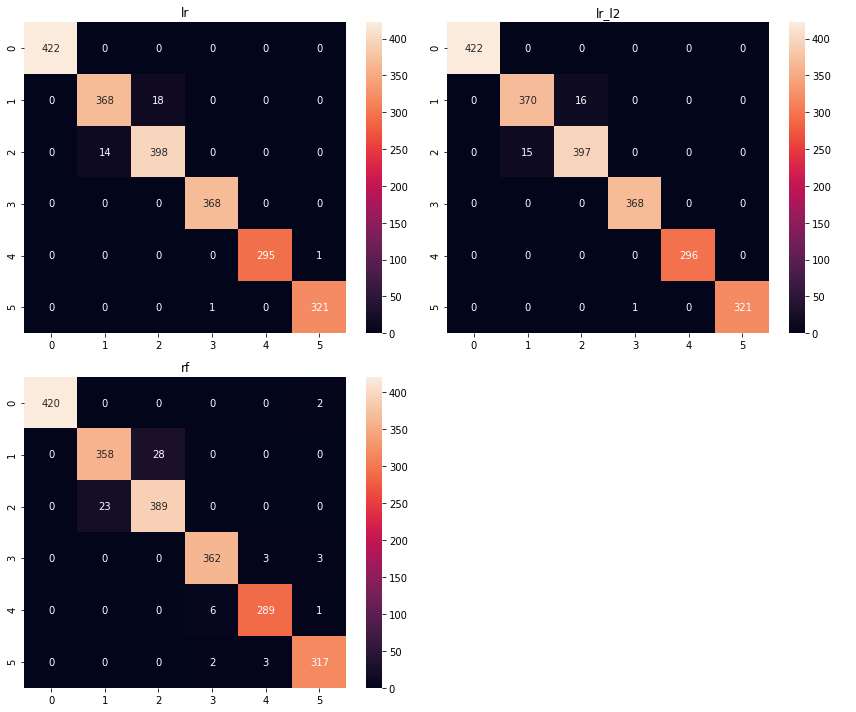

In [51]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], labels):
    sns.heatmap(confusion_m[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


### Observations about Error Metrics and Ridge Regression

We can see that the Logistic regression with L2 regularization gives slightly better error metric than the other models.  The question we ask here is: What happens when we discard the most correlated feature? Will we have a better model? The answer is typically yes, we will get better results with we remove highly correlated features. We are addressing the 'curse of dimensionality' and the idea that too much correlated data in our experiment can cause it to be 'overfit' and will not be very effective working with similar data.

In following workshops, we'll learn more about cross-validation and using confusion matrices to check the performance and accuracy of our models.